# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn import set_config
set_config(transform_output='pandas')

# Load data

In [2]:
data = "Data/cust_seg.csv"
df = pd.read_csv(data)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Customer Id      850 non-null    int64  
 2   Age              850 non-null    int64  
 3   Edu              850 non-null    int64  
 4   Years Employed   850 non-null    int64  
 5   Income           850 non-null    int64  
 6   Card Debt        850 non-null    float64
 7   Other Debt       850 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


Calling value_counts on defaulted, only 700 non_null count and will check for duplicated

In [3]:
df['Defaulted'].value_counts(dropna=False)

0.0    517
1.0    183
NaN    150
Name: Defaulted, dtype: int64

Checking for duplicates

In [4]:
df.duplicated().sum()

0

Droping null values

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       700 non-null    int64  
 1   Customer Id      700 non-null    int64  
 2   Age              700 non-null    int64  
 3   Edu              700 non-null    int64  
 4   Years Employed   700 non-null    int64  
 5   Income           700 non-null    int64  
 6   Card Debt        700 non-null    float64
 7   Other Debt       700 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  700 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 60.2 KB


All numeric values (int/float).  Calling describe to get over all view

In [6]:
df.describe()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,429.461429,430.461429,34.860000,1.722857,8.388571,45.601429,1.553566,3.058196,0.261429,10.260571
std,243.323524,243.323524,7.997342,0.928206,6.658039,36.814226,2.117196,3.287550,0.439727,6.827234
min,0.000000,1.000000,20.000000,1.000000,0.000000,14.000000,0.012000,0.046000,0.000000,0.400000
25%,221.750000,222.750000,29.000000,1.000000,3.000000,24.000000,0.368750,1.044000,0.000000,5.000000
50%,432.500000,433.500000,34.000000,1.000000,7.000000,34.000000,0.855000,1.987500,0.000000,8.600000
75%,641.250000,642.250000,40.000000,2.000000,12.000000,55.000000,1.901750,3.923250,1.000000,14.125000
max,849.000000,850.000000,56.000000,5.000000,31.000000,446.000000,20.561000,27.034000,1.000000,41.300000


Income, card debt, and other debt looks to have some outliers but, but feel values are possible.  Also realize unamed:0 and Customer id may be be index, will drop both column

In [7]:
df = df.drop(['Unnamed: 0', 'Customer Id'],axis=1)
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,0.0,6.3
1,47,1,26,100,4.582,8.218,0.0,12.8
2,33,2,10,57,6.111,5.802,1.0,20.9
3,29,2,4,19,0.681,0.516,0.0,6.3
4,47,1,31,253,9.308,8.908,0.0,7.2


Feature engineering:  Total debt column

In [8]:
df['Total Debt'] = df['Card Debt'] = df['Other Debt']
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt
0,41,2,6,19,1.073,1.073,0.0,6.3,1.073
1,47,1,26,100,8.218,8.218,0.0,12.8,8.218
2,33,2,10,57,5.802,5.802,1.0,20.9,5.802
3,29,2,4,19,0.516,0.516,0.0,6.3,0.516
4,47,1,31,253,8.908,8.908,0.0,7.2,8.908


Decided to keep all debt columns

In [9]:
#df = df.drop(columns=['Card Debt', 'Other Debt'])
#df.head()

# Scaling

In [10]:
scale = StandardScaler()
scaled_df = scale.fit_transform(df)
scaled_df

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt
0,0.768304,0.298793,-0.359007,-0.723102,-0.604284,-0.604284,-0.594950,-0.580528,-0.604284
1,1.519090,-0.779325,2.647029,1.478707,1.570620,1.570620,-0.594950,0.372222,1.570620
2,-0.232744,0.298793,0.242201,0.309845,0.835201,0.835201,1.680814,1.559495,0.835201
3,-0.733267,0.298793,-0.659610,-0.723102,-0.773833,-0.773833,-0.594950,-0.580528,-0.773833
4,1.519090,-0.779325,3.398538,5.637681,1.780653,1.780653,-0.594950,-0.448609,1.780653
...,...,...,...,...,...,...,...,...,...
844,0.768304,-0.779325,-0.208705,-0.070714,-0.566235,-0.566235,-0.594950,-0.859025,-0.566235
846,-0.858398,0.298793,-0.208705,-0.315360,-0.315718,-0.315718,-0.594950,-0.477925,-0.315718
847,-1.233791,2.455029,-1.260817,-0.750285,0.046209,0.046209,1.680814,3.391707,0.046209
848,-0.357875,-0.779325,0.542804,-0.478457,-0.719041,-0.719041,-0.594950,-1.078890,-0.719041


# Inertias

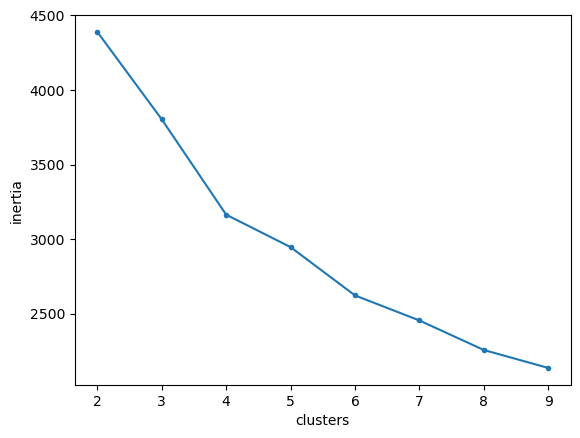

In [11]:
#Create an empty list of inertias
inertias = []
#Loop trhough k values betwen 2 and 10 and store the inertias in the list
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, n_init = 'auto', random_state = 42)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
#Visualize score
plt.plot(range(2,10), inertias, marker ='.')
plt.xlabel('clusters')
plt.ylabel('inertia');


looks like 3 clusters but may have too many features to clearly visulize clusters

# Silhouette

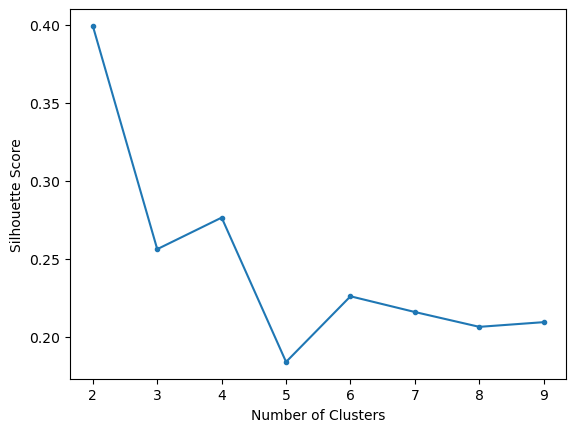

In [12]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 10):
  kmeans = KMeans(n_clusters = i, n_init = 'auto', random_state = 42)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 10), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');



2 had higest silhouette score follow by 3 but an increas in score at 6 also.  Going to graph 2 and 3

In [13]:
# Fit 2 different KMeans models, one with 2 clusters and one with 3 clusters
kmeans2 = KMeans(n_clusters = 3, random_state=42)
kmeans3 = KMeans(n_clusters = 4, random_state=42)
kmeans2.fit(scaled_df)
kmeans3.fit(scaled_df)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

Using Incme and Total debt colored by clusters to visualize data

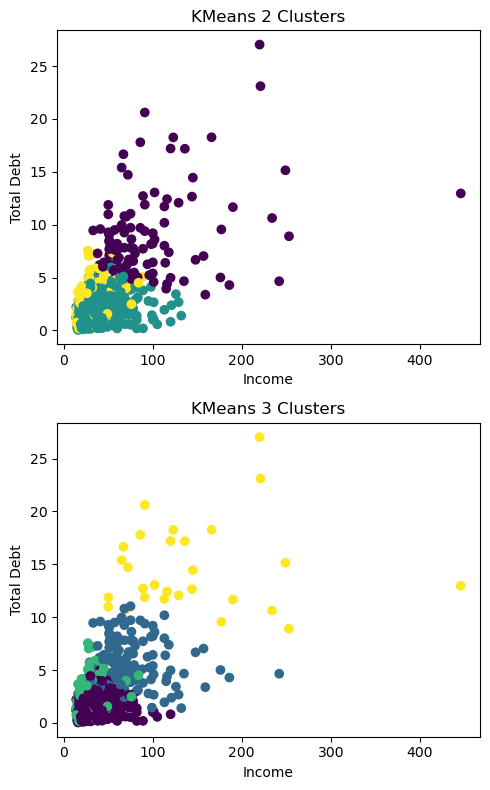

In [14]:
# Save the cluster labels to the dataframe 
df['cluster2'] = kmeans2.labels_
df['cluster3'] = kmeans3.labels_
# Visualize the clusters
fig, axes = plt.subplots(2,1, figsize=(5,8))
axes[0].scatter(df['Income'], df['Total Debt'], c = df['cluster2'])
axes[0].set_xlabel('Income')
axes[0].set_ylabel('Total Debt')
axes[0].set_title('KMeans 2 Clusters')
axes[1].scatter(df['Income'], df['Total Debt'], c = df['cluster3'])
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Total Debt')
axes[1].set_title('KMeans 3 Clusters')
plt.tight_layout();

Using Income and Debt Income Ration colored by clusters to visualize data

In [ ]:
# Save the cluster labels to the dataframe 
df['cluster2'] = kmeans2.labels_
df['cluster3'] = kmeans3.labels_
# Visualize the clusters
fig, axes = plt.subplots(2,1, figsize=(5,8))
axes[0].scatter(df['Income'], df['DebtIncomeRatio'], c = df['cluster2'])
axes[0].set_xlabel('Income')
axes[0].set_ylabel('DebtIncomeRatio')
axes[0].set_title('KMeans 2 Clusters')
axes[1].scatter(df['Income'], df['DebtIncomeRatio'], c = df['cluster3'])
axes[1].set_xlabel('Income')
axes[1].set_ylabel('DebtIncomeRatio')
axes[1].set_title('KMeans 3 Clusters')
plt.tight_layout();

Cluster are not well defined but feel 4 clusters had best inertias and silhouette score

In [19]:
# Refit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, n_init= 'auto', random_state=42)
kmeans.fit(scaled_df)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()


,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt,cluster2,cluster3,cluster
0,41,2,6,19,1.073,1.073,0.0,6.3,1.073,1,0,3
1,47,1,26,100,8.218,8.218,0.0,12.8,8.218,0,1,0
2,33,2,10,57,5.802,5.802,1.0,20.9,5.802,2,2,0
3,29,2,4,19,0.516,0.516,0.0,6.3,0.516,1,0,3
4,47,1,31,253,8.908,8.908,0.0,7.2,8.908,0,3,2


In [20]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups


,cluster,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt,cluster2,cluster3
0,0,41.448529,1.867647,14.801471,73.772059,6.007537,6.007537,0.198529,14.398529,6.007537,0.500000,1.080882
1,1,30.891892,1.817568,3.351351,28.425676,2.295689,2.295689,0.979730,13.320270,2.295689,2.000000,2.000000
2,2,42.840000,2.400000,17.520000,153.800000,15.044720,15.044720,0.440000,17.284000,15.044720,0.000000,3.000000
3,3,33.560102,1.593350,7.480818,35.386189,1.554558,1.554558,0.000000,7.214066,1.554558,1.002558,0.007673


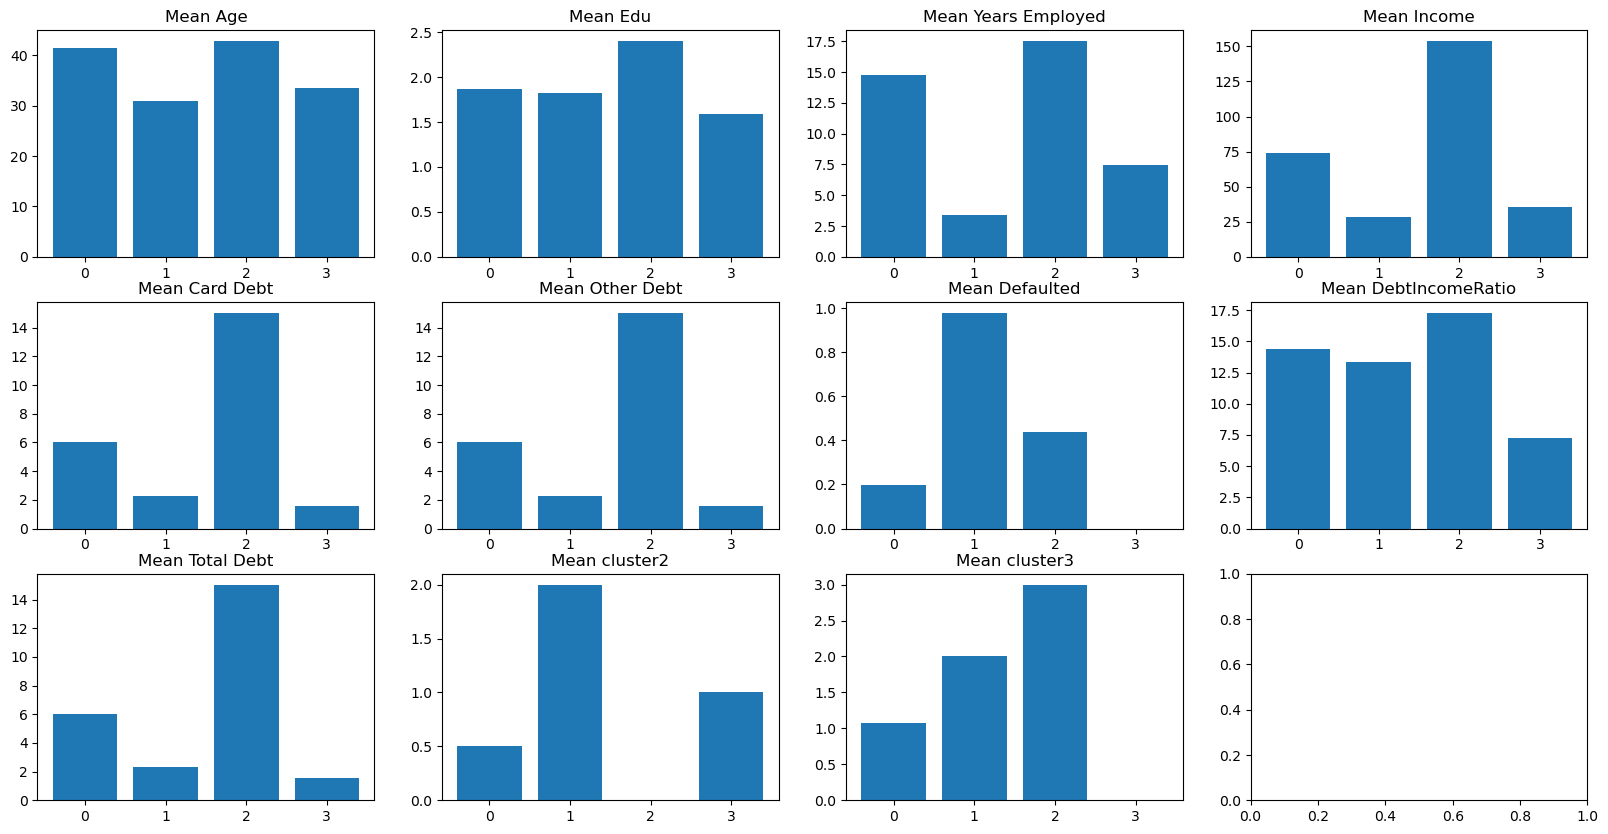

In [21]:
# Visualize means 
fig, axes = plt.subplots(3,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')



# Cluster 0

Avg age a little over 40.  15 years avg employment.  75,000 avg income.  Debt is avg, not high not low.  Stratagy: No intrest balanace transfers for 2 years.  Low interest rates.  No annual fees. Increased 'cash back' program focused on travel, eating out and entertainment.  Programs linked to busness such as hotels, resturants, airlines and car rental for discounts.  Cards availbe to other family members upon sign up.

# Cluster 1

Avg age 30. 2.5 years avg employment.  Lowest avg income, 25,000.  Second lowest avg debt. High rate of default.  Stratagy:  No intrest balanace transfers for 2 years.  No interest rates for the first year and low interest rates following that.  No annual fees.  "Cash back" program.  Free programs to help with money managment.  Free items with sigh up, such as shirts, bag, cash(signing bonus), etc.  

# Cluster 2

Oldest age group amonge cluster with avg age 45.  Higest education, avg years employment and income.  Low rate of defalut ~40%.  Stratagy: No intrest balanace transfers for 2 years.  Low interest rates.  No annual fees. Increased 'cash back' program focused on travel, eating out and entertainment.  Programs linked to busness such as hotels, resturants, airlines and car rental for discounts.  Spouse card offered upon sign up.  

# Cluster 3

Avg age above 30.  Lowest edu avg.  Second lowest avg years employed at 7.  About 30,000 avg income.  Lowest over debt and little to no defaults.  Strategy:  No intrest balanace transfers for 2 years.  No interest rates for the first year and low interest rates following that.  No annual fees.  "Cash back" program.  High spending limit.  Free items with sigh up, such as shirts, bag, cash(signing bonus), etc.  Sleek looking all black credit card.  